# AMAL // Prise en main de PyTorch
                        notebook n°1 sur 3

PyTorch sera notre principal allié en AMAL. Les trois premières séances servent de visite guidée.

Les sources additionnelles suivantes ont été utiles :  
https://pytorch.org/tutorials/beginner/pytorch_with_examples.html  
https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html  
https://discuss.pytorch.org/t/what-is-the-recommended-way-to-re-assign-update-values-in-a-variable-or-tensor/6125

In [1]:
# /////////////////////////////////////////////////////////////////////////////////////////// <useful libraries> ////

# Ne pas oublier d'executer dans le shell avant de lancer python :
# source /users/Enseignants/piwowarski/venv/amal/3.7/bin/activate

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Function, gradcheck
import random
import numpy as np

# Output formatting
fred = "\033[91m"
fgrn = "\033[92m"
fbld = "\033[1m"
fend = "\033[0m"

# ////////////////////////////////////////////////////////////////////////////////////////// </useful libraries> ////

Avant d'utiliser les fonctions classiques de PyTorch, il faut prouver notre compréhension de la régression linéaire en implémentant ses éléments à la main. Nous n'aurons plus à le faire par la suite.  
Nos efforts se concentrent sur la compréhension des dimensions du problème, d'où les clauses `assert` omniprésentes dans les fonctions (pratique conseillée pour toute vérification d'ordre théorique). On apprend également à manipuler des objets `Tensor` et à faire la différence entre `torch.matmul` et `torch.mm` (qu'on abrège avec `@`). 

### Table des matières

<a href='#regl'>Régression linéaire et fonction de coût MSE</a>  
<a href='#vera'>Vérification automatique</a>  
<a href='#desc'>Descente de gradient basique</a>  
&nbsp;&nbsp;Expérimentations sur le pas de gradient //

### Régression linéaire et fonction de coût MSE <a id='regl'></a>

Les classes que nous allons créer -  
(une pour le calcul du coût par itération, ici MSE, l'autre pour une étape de transformation linéaire)  
ont deux méthodes, `forward` et `backward`. Ce découpage suit la logique interne de PyTorch.  

Dans un réseau de neurones, l'information brute transite à travers plusieurs couches de fonctions en subissant alternativement des transformations linéaires et non-linéaires. A la sortie, on lui associe donc une valeur estimée.  
En apprentissage supervisé, on représente ensuite la différence entre cette estimation et une étiquette cible via une fonction de coût. On peut alors rétropropager le gradient de ce coût et mettre à jour les paramètres de chaque couche. En utilisant les nouveaux paramètres, on devrait obtenir une estimation plus proche de la valeur attendue.  
L'apprentissage se fait en répétant cette boucle jusqu'à ce qu'on atteigne un critère d'arrêt : soit une convergence tangible, soit un compte d'itérations arbitraire.   

Il y a donc deux dynamiques complémentaires à chaque itération - un mouvement en avant, puis un autre en arrière - et notre code doit le montrer.

In [2]:
# ///////////////////////////////////////////////////////////////////// <getting started with linear regression> ////

class Context:
    # A basic object to simulate automated PyTorch-powered executions
    # A new context must be created at *every* run
    def __init__(self):
        self._saved_tensors = ()
    def save_for_backward(self, *args):
        self._saved_tensors = args
    @property
    def saved_tensors(self):
        return self._saved_tensors

    
class MSE(Function):
    # A Mean-Squared-Error loss function 
    @staticmethod
    def forward(ctx,yhat,y):
        # Saving data for the backprop
        ctx.save_for_backward(yhat, y)
        # Using the formula
        diff = torch.sum(torch.pow(y-yhat,2)) / y.nelement()
        # Verifying the shapes
        assert(diff.shape == ())
        assert(y.shape == yhat.shape)
        return diff
    
    @staticmethod
    def backward(ctx,grad_output):
        # Retrieving past events from the current context
        yhat,y = ctx.saved_tensors
        # Computing the gradient of the loss wrt/ each variable
        Ly = 2*(y-yhat)*grad_output / y.nelement()
        Lyhat = -Ly
        # Verifying the shapes
        assert(y.shape == yhat.shape)
        assert(Ly.shape == y.shape)
        assert(Lyhat.shape == yhat.shape)
        return Lyhat, Ly
        
        
class Linear(Function):
    @staticmethod
    def forward(ctx,X,W,b):
        # Saving data for the backprop
        ctx.save_for_backward(X,W,b)
        # Verifying the shapes
        assert(X.shape[1] == W.shape[0])
        assert((X@W).shape[1] == b.shape[1])
        # Applying a linear transformation
        return X @ W + b
    
    @staticmethod 
    def backward(ctx,grad_output):  
        # Retrieving past events from the current context
        X,W,b = ctx.saved_tensors
        # Computing the gradient of the loss wrt/ each variable
        Lx = grad_output @ W.t()
        Lw = X.t() @ grad_output
        Lb = grad_output.sum(0).view(1,-1)
        # Verifying the shapes
        assert(X.shape[1] == W.shape[0])
        assert(Lw.shape == W.shape)
        assert(Lx.shape == X.shape)
        assert(Lb.shape == b.shape)
        return Lx, Lw, Lb  

# //////////////////////////////////////////////////////////////////// </getting started with linear regression> ////

### Vérification automatique <a id='vera'></a>

Pour assurer nos arrières, PyTorch offre une technique de vérification du gradient par différence finie :

In [3]:
# ////////////////////////////////////////////////////////////////////////////////////////// <gradient checking> ////

mse = MSE.apply 
lin = Linear.apply

# Testing the MSE loss gradient
yhat = torch.randn(10,5, requires_grad=True, dtype=torch.float64)
y = torch.randn(10,5, requires_grad=True, dtype=torch.float64)
if torch.autograd.gradcheck(mse,(yhat,y)):
    print(fgrn+"Checked it! "+fend+"Your MSE class works like a charm. Want some chocolate?")

# Testing the linear transformation gradient
X = torch.randn(10,5, requires_grad=True, dtype=torch.float64)
W = torch.randn(5,3, requires_grad=True, dtype=torch.float64)
b = torch.randn(1,3, requires_grad=True, dtype=torch.float64)
if torch.autograd.gradcheck(lin,(X,W,b)):
    print(fgrn+"Checked it! "+fend+"Your Linear class works like a charm. You really deserve CHOCOLATE")
    
# ///////////////////////////////////////////////////////////////////////////////////////// </gradient checking> ////

Checked it! Your MSE class works like a charm. Want some chocolate?
Checked it! Your Linear class works like a charm. You really deserve CHOCOLATE


### Descente de gradient basique <a id='desc'></a>

Le `gradcheck` est rassurant, on peut donc lancer une descente de gradient sur des données jouets :

In [4]:
# /////////////////////////////////////////////////////////////////////////////////////////// <gradient descent> ////

def gradDescent(X,Y,W,b,appmse,applin,epsilon=0.01,itecond=True):
    # Set itecond to True if you're wishing to limitate the descent to 1000 iterations.
    
    print("\n"+fbld+"--------------------------------- BATCH GRADIENT DESCENT -----------------------------------\n"+fend)
    loss = np.inf
    
    # Saving the results for TensorBoard visualisation
    writer = SummaryWriter()
    
    nIter = 0
    # Iterating until convergence is reached
    while loss>0.70:
        
        # Declaring new contexts
        ctxLin = Context()
        ctxMSE = Context()
        # Applying linear transformation + loss computation
        fwd = lin.forward(ctxLin, X, W, b)
        loss = mse.forward(ctxMSE, fwd, Y)
        # Saving the loss and printing it every 100 iterations
        writer.add_scalar('Loss/train/FIRSTGRADIENTEPS', loss, nIter)
        if nIter%100 == 0: print(f"Iterations|\t TRAIN {nIter}: loss {loss}")
        # Backpropagation
        gradFwd, gradY = mse.backward(ctxMSE, 1)
        gradX, gradW, gradb = lin.backward(ctxLin, gradFwd)
        # Updating the parameters
        W = W - epsilon*gradW  
        b = b - epsilon*gradb
        nIter += 1
        
        # Breaking the loop if had enough
        if itecond and nIter>1000:
            print(fred+"\t\t.......Broke the loop without converging."+fend)
            return W, b
    
    print(fgrn+"\t\t.......Convergence reached at n ="+fend,nIter)
    return W, b   


torch.manual_seed(42)
# A toy dataset (13D data, 3D labels)
X = torch.randn(50,13)
Y = torch.randn(50,3)
# Linear regression parameters
W = torch.randn(13,3)
b = torch.randn(1,3)
# Hyperparameters (learning rate)
# Found 10e-2 to work best.
epsilon = 0.01

mse = MSE()
lin = Linear()
# Lauching the descent
W, b = gradDescent(X,Y,W,b,mse,lin,epsilon,itecond=False)

print("\n"+fbld+"------------------------------------- FINAL ESTIMATES ---------------------------------------\n"+fend)
print("FINAL W equals\n\\",W)
print("\nFINAL b equals\n\\",b)
print("\n"+fbld+"---------------------------------------------------------------------------------------------"+fend)

# ////////////////////////////////////////////////////////////////////////////////////////// </gradient descent> ////


--------------------------------- BATCH GRADIENT DESCENT -----------------------------------

Iterations|	 TRAIN 0: loss 13.683131217956543
Iterations|	 TRAIN 100: loss 3.8613688945770264
Iterations|	 TRAIN 200: loss 1.715874195098877
Iterations|	 TRAIN 300: loss 1.1225910186767578
Iterations|	 TRAIN 400: loss 0.9144628047943115
Iterations|	 TRAIN 500: loss 0.823387622833252
Iterations|	 TRAIN 600: loss 0.7760976552963257
Iterations|	 TRAIN 700: loss 0.7486281991004944
Iterations|	 TRAIN 800: loss 0.7315547466278076
Iterations|	 TRAIN 900: loss 0.7205025553703308
Iterations|	 TRAIN 1000: loss 0.7131637930870056
Iterations|	 TRAIN 1100: loss 0.7082083225250244
Iterations|	 TRAIN 1200: loss 0.7048220634460449
Iterations|	 TRAIN 1300: loss 0.702488899230957
Iterations|	 TRAIN 1400: loss 0.7008704543113708
		.......Convergence reached at n = 1475

------------------------------------- FINAL ESTIMATES ---------------------------------------

FINAL W equals
\ tensor([[ 0.2516, -0.1394,  0.0

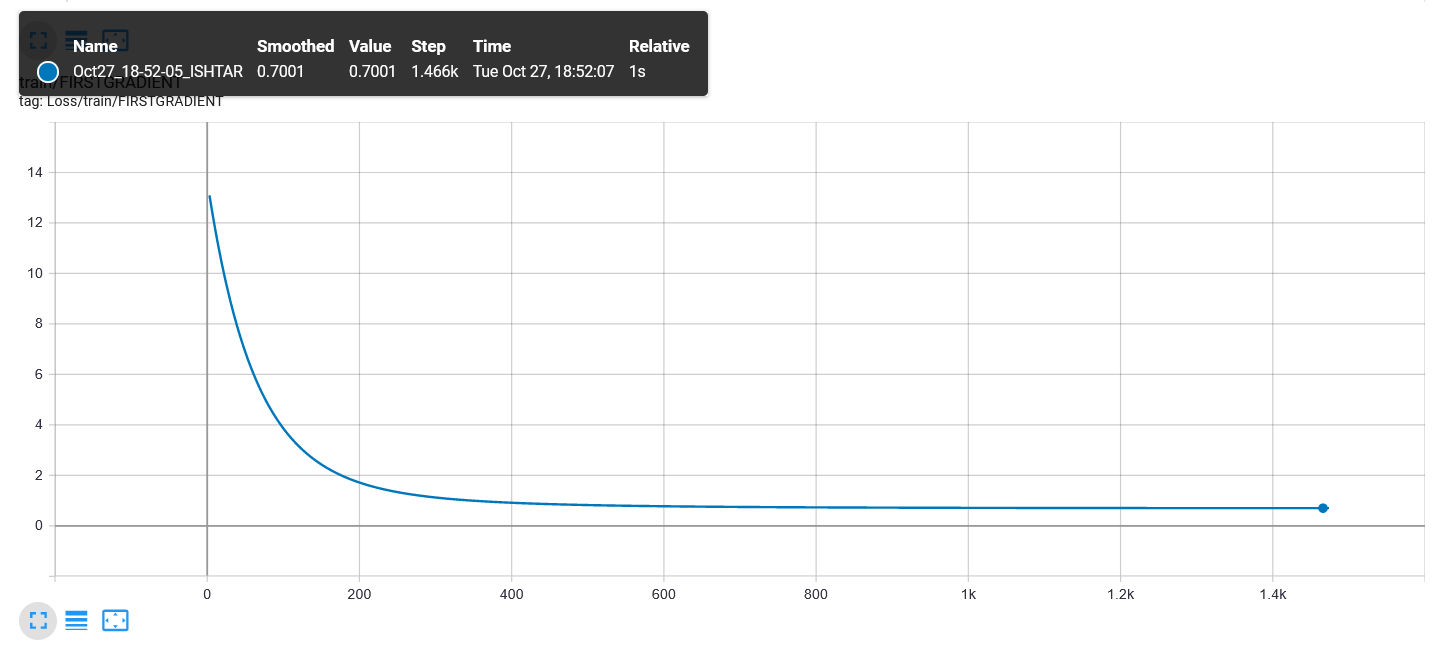

Ce sont nos premiers pas avec l'outil de visualisation TensorBoard. On note la possibilité de retenir la durée d'exécution, la date du lancement, et le numéro de l'itération associée à chaque valeur.  

Sémantiquement, c'est correct. La courbe est exemplaire : le coût de l'apprentissage diminue de plus en plus lentement au fil des itérations et converge vers zéro. 

##### Expérimentations sur le pas de gradient

Connaissant l'impact du pas d'apprentissage ε sur ce phénomène, on tente la démonstration suivante avec des valeurs plus ou moins élevées :

In [5]:
# Setting new linear regression parameters
torch.manual_seed(42)
W = torch.randn(13,3)
b = torch.randn(1,3)
# Hyperparameters (learning rate)
epsilon = 0.0001

# itecond = True >>> capping to 1000 iterations
W, b = gradDescent(X,Y,W,b,mse,lin,epsilon,itecond=True)

print("\n"+fbld+"------------------------------------- FINAL ESTIMATES ---------------------------------------\n"+fend)
print("FINAL W equals\n\\",W)
print("\nFINAL b equals\n\\",b)
print("\n"+fbld+"---------------------------------------------------------------------------------------------"+fend)


--------------------------------- BATCH GRADIENT DESCENT -----------------------------------

Iterations|	 TRAIN 0: loss 17.9472599029541
Iterations|	 TRAIN 100: loss 17.655855178833008
Iterations|	 TRAIN 200: loss 17.370189666748047
Iterations|	 TRAIN 300: loss 17.09012794494629
Iterations|	 TRAIN 400: loss 16.81555938720703
Iterations|	 TRAIN 500: loss 16.546363830566406
Iterations|	 TRAIN 600: loss 16.282432556152344
Iterations|	 TRAIN 700: loss 16.023635864257812
Iterations|	 TRAIN 800: loss 15.769881248474121
Iterations|	 TRAIN 900: loss 15.521051406860352
Iterations|	 TRAIN 1000: loss 15.277046203613281
		.......Broke the loop without converging.

------------------------------------- FINAL ESTIMATES ---------------------------------------

FINAL W equals
\ tensor([[ 1.8660,  1.4066,  0.9033],
        [-1.9364,  0.5684, -1.1570],
        [-0.0041, -1.5348, -0.7088],
        [ 1.5068, -0.3248, -1.3145],
        [-0.7381, -0.5458, -0.6952],
        [ 0.7802,  1.5446, -0.1299],
   

In [6]:
# Setting new linear regression parameters
torch.manual_seed(42)
W = torch.randn(13,3)
b = torch.randn(1,3)
# Hyperparameters (learning rate)
epsilon = 0.5

# itecond = True >>> capping to 1000 iterations
W, b = gradDescent(X,Y,W,b,mse,lin,epsilon,itecond=True)

print("\n"+fbld+"------------------------------------- FINAL ESTIMATES ---------------------------------------\n"+fend)
print("FINAL W equals\n\\",W)
print("\nFINAL b equals\n\\",b)
print("\n"+fbld+"---------------------------------------------------------------------------------------------"+fend)


--------------------------------- BATCH GRADIENT DESCENT -----------------------------------

Iterations|	 TRAIN 0: loss 17.9472599029541
		.......Convergence reached at n = 30

------------------------------------- FINAL ESTIMATES ---------------------------------------

FINAL W equals
\ tensor([[ 0.3148, -0.1119,  0.0789],
        [-0.0878,  0.0507,  0.1195],
        [ 0.1559,  0.0651,  0.0637],
        [ 0.0054,  0.3591,  0.0643],
        [-0.3569, -0.0397, -0.1115],
        [ 0.3031, -0.1621,  0.1349],
        [-0.0824,  0.2828, -0.0095],
        [ 0.3786, -0.0582, -0.1019],
        [-0.2875,  0.2383,  0.2283],
        [ 0.5669,  0.0649,  0.0444],
        [ 0.0649, -0.3077,  0.1587],
        [-0.0592, -0.2769,  0.0353],
        [-0.1489,  0.3589, -0.2914]])

FINAL b equals
\ tensor([[-0.2921, -0.0548, -0.1327]])

---------------------------------------------------------------------------------------------


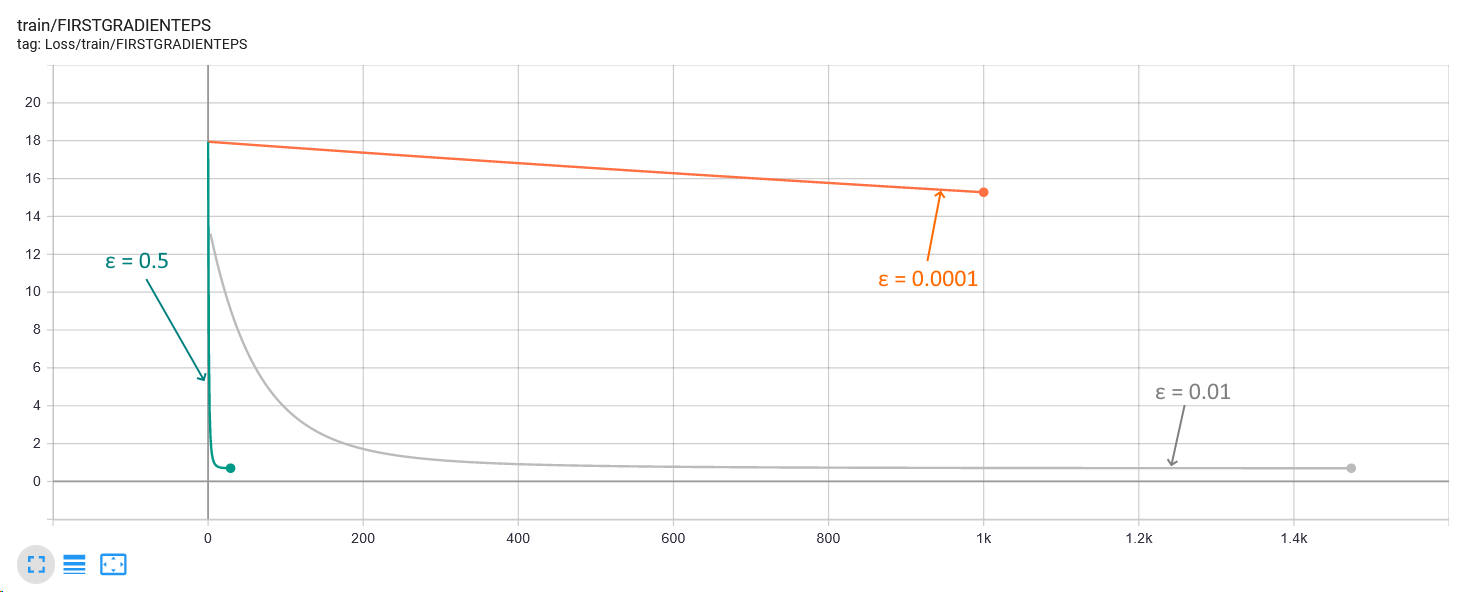

On constate que prendre un pas de gradient ε plus grand provoque un apprentissage extrêmement rapide. Sur de vraies données, une telle idée risque même de le compromettre en faisant exploser le gradient dès la première itération (ε = 0.5 n'est généralement même pas une valeur envisageable).  
A l'inverse, un apprentissage sur un ε très petit est aussi lent que prudent. Le coût finirait par converger à terme, dans un certain temps.

**Rappelons qu'un modèle qui apprend explore la surface de la fonction de coût et a pour objectif de le minimiser.  
Apprendre vite, avec un grand ε, c'est parcourir très vite cette surface et potentiellement "rater" ses minima globaux.  
Apprendre trop lentement, avec un petit ε, c'est se concentrer sur une toute petite région en oubliant d'aller voir plus loin.**

Il existe une foison d'autres paramètres auxquels le modèle est plus ou moins sensible, mais le pas de gradient reste absolument essentiel. L'art en ML est de trouver le juste équilibre entre eux.

### Conclusions

Aucune notion nouvelle n'a encore été explorée dans ce TME.  
Cependant, on y a acquis de nouveaux réflexes de programmation.

Voir l'application au dataset Boston Housing au TME suivant.